# Virtual Acoustic Environments Spring 2022
## Project 9: Headphone Equalization
**Author: Alpar Gür**

**Supervisor: David Bau**

**Professor: Christoph Pörschmann**

---
This notebook is to extract and write the impulse responses recorded from Beats Detox headphone.

In [11]:
# import packages
import numpy as np
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, fft, ifft
from collections import defaultdict
from numpy import ndarray, ceil, log2, append

from shared.record_signal import convert_audio_to_numpy_array, play_sound

In [12]:
# define global parameters
fs = 44100
nyquist = fs / 2.0
recording_count = 10
headphones = ['Beats_Detox']

In [26]:
# import sweep sound
sweep_sound, sweep_fs = convert_audio_to_numpy_array(f"../sounds/input/sweep_fs_44100_mono.wav")
sweep_sound = sweep_sound[:52920] # crop silence after sweep
print('Audio:\t\t Sweep')
print(f'Sample Rate:\t {sweep_fs}')
print(f"Shape:\t\t {sweep_sound.shape}")

Audio:		 Sweep
Sample Rate:	 44100
Shape:		 (52920,)


In [27]:
sd.play(sweep_sound, fs)

Get sweep sound recordings for each headphone

In [28]:
# get sweep sound recordings for headphone(s)
headphone_sweep_sounds = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    for i in range(recording_count):
        sweep, fs = convert_audio_to_numpy_array(f"../sounds/sweeps/{headphone}/pass0{i}.wav")
        sweep = sweep[:52920] # crop silence after sweep
        headphone_sweep_sounds[headphone][i] = sweep
    headphone_sweep_sounds[headphone]['fs'] = fs
    print(f'Sample Rate:\t {fs}')
    print(f'Shape:\t\t {sweep.shape}')

Headphone:	 Beats_Detox
Sample Rate:	 44100
Shape:		 (52920, 2)


In [29]:
# play the first sweep from the list
sd.play(headphone_sweep_sounds['Beats_Detox'][0], fs)

Visualize Sweep Sound and Recorded L|R Channels

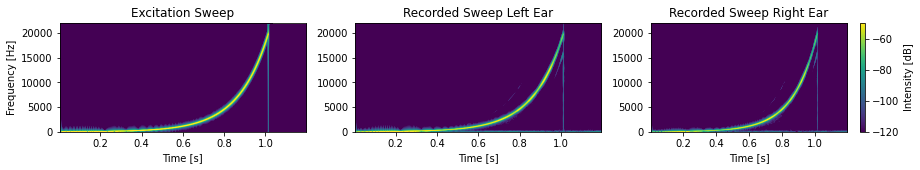

In [30]:
y_l = headphone_sweep_sounds['Beats_Detox'][0][:, 0]
y_r = headphone_sweep_sounds['Beats_Detox'][0][:, 1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2))

ax1.set_title('Excitation Sweep')
ax1.set_ylabel("Frequency [Hz]")
ax1.set_xlabel("Time [s]")

ax2.set_title('Recorded Sweep Left Ear')
ax2.set_xlabel("Time [s]")

ax3.set_title('Recorded Sweep Right Ear')
ax3.set_xlabel("Time [s]")

v_min = -120
v_max = -50

_, _, _, cax1 = ax1.specgram(sweep_sound+0.000001, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)
_, _, _, cax2 = ax2.specgram(y_l, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)
_, _, _, cax3 = ax3.specgram(y_r, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)

fig.colorbar(cax3, ax=ax3).set_label('Intensity [dB]')

### Deconvolution

In [31]:
def pad_array(recording: ndarray):
    input_length = recording.size
    n = ceil(log2(input_length)) + 1
    N_fft = int(pow(2, n))
    N_one_sided = (N_fft / 2) + 1
    n_one_sided = (recording.shape[0] / 2) + 1

    print(f'Input Length:\t {input_length}')
    print(f'n:\t\t {n}')
    print(f'N_fft:\t\t {N_fft}')
    print(f'N_one_sided:\t {N_one_sided}')
    print(f'n_one_sided:\t {n_one_sided}')

    return input_length, n, N_fft, N_one_sided, n_one_sided

In [32]:
input_length, n, N_fft, N_one_sided, n_one_sided = pad_array(headphone_sweep_sounds['Beats_Detox'][0])

Input Length:	 105840
n:		 18.0
N_fft:		 262144
N_one_sided:	 131073.0
n_one_sided:	 26461.0


In [33]:
# def transform_time_to_frequency_domain(audio: ndarray, recording: ndarray):
#     y_l = recording[:, 0] # left channel
#     y_r = recording[:, 1] # right channel
#     
#     X_f = fft(audio)
#     Yl_f = fft(y_l)
#     Yr_f = fft(y_r)
# 
#     frequency_components = {
#         'y_l': y_l, 
#         'y_r': y_r, 
#         'X_f': X_f, 
#         'Yl_f': Yl_f, 
#         'Yr_f': Yr_f
#     }
# 
#     return frequency_components
def transform_time_to_frequency_domain(audio: ndarray, recording: ndarray, N_fft: int):
    y_l = recording[:, 0] # left channel
    y_r = recording[:, 1] # right channel
    
    X_f = rfft(audio, 52920)
    Yl_f = rfft(y_l, 52920)
    Yr_f = rfft(y_r, 52920)

    frequency_components = {
        'y_l': y_l, 
        'y_r': y_r, 
        'X_f': X_f, 
        'Yl_f': Yl_f, 
        'Yr_f': Yr_f
    }
    return frequency_components

In [34]:
headphone_frequency_components = defaultdict(dict)

for headphone in headphones:
    print(f'Headphone:\t {headphone}')
    for count in range(recording_count):
        headphone_frequency_components[headphone][count] = transform_time_to_frequency_domain(sweep_sound, headphone_sweep_sounds[headphone][count], N_fft)
    y_l_shape = headphone_frequency_components[headphone][0]['y_l'].shape
    y_r_shape = headphone_frequency_components[headphone][0]['y_r'].shape
    X_f_shape = headphone_frequency_components[headphone][0]['X_f'].shape
    Yl_f_shape = headphone_frequency_components[headphone][0]['Yl_f'].shape
    Yr_f_shape = headphone_frequency_components[headphone][0]['Yr_f'].shape
    print(f"Shape y_l:\t\t {y_l_shape}")
    print(f"Shape y_r:\t\t {y_r_shape}")
    print(f"Shape X_f:\t\t {X_f_shape}")
    print(f"Shape Yl_f:\t\t {Yl_f_shape}")
    print(f"Shape Yr_f\t\t {Yr_f_shape}")

Headphone:	 Beats_Detox
Shape y_l:		 (52920,)
Shape y_r:		 (52920,)
Shape X_f:		 (26461,)
Shape Yl_f:		 (26461,)
Shape Yr_f		 (26461,)
